In [1]:
# -*- coding: utf-8 -*-
# 美吉姆走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# 数据加载
df = pd.read_csv('002621_2011_9_20_to_2020_9_4.csv')
df = df[['Timestamp', 'Price']]

In [2]:
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)

            Timestamp  Price
Timestamp                   
2020-09-04 2020-09-04   7.10
2020-09-03 2020-09-03   7.15
2020-09-02 2020-09-02   7.16
2020-09-01 2020-09-01   7.15
2020-08-31 2020-08-31   7.20
                Price
Timestamp            
2011-09-30  15.590000
2011-10-31  25.367500
2011-11-30  26.827727
2011-12-31  22.894545
2012-01-31  20.243333
2012-02-29  22.527619
2012-03-31  22.050000
2012-04-30  13.653529
2012-05-31  13.848182
2012-06-30  14.032000
2012-07-31  11.274091
2012-08-31  11.367391
2012-09-30  11.408500
2012-10-31  11.420000
2012-11-30  11.025909
2012-12-31  11.286190
2013-01-31  11.942000
2013-02-28  12.126000
2013-03-31  12.717619
2013-04-30  11.426111
2013-05-31  11.722273
2013-06-30  12.394706
2013-07-31  12.399565
2013-08-31  12.492727
2013-09-30  12.739474
2013-10-31  12.845556
2013-11-30  12.629524
2013-12-31  13.919091
2014-01-31  13.603810
2014-02-28  14.907500
...               ...
2018-04-30  14.087778
2018-05-31  15.071818
2018-06-30   3.820500
2018-

In [3]:

# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                             Statespace Model Results                           
Dep. Variable:                  Price   No. Observations:                  109
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -306.658
Date:                Sun, 06 Sep 2020   AIC                            625.315
Time:                        18:58:31   BIC                            641.123
Sample:                    09-30-2011   HQIC                           631.718
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6361      0.202      3.144      0.002       0.240       1.033
ma.L1         -0.9556    241.437     -0.004      0.997    -474.163     472.252
ma.L2         -0.0095     10.801     -0.001  

In [4]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

date_list= [Timestamp('2020-10-31 00:00:00', freq='M'), Timestamp('2020-11-30 00:00:00', freq='M'), Timestamp('2020-12-31 00:00:00', freq='M')]


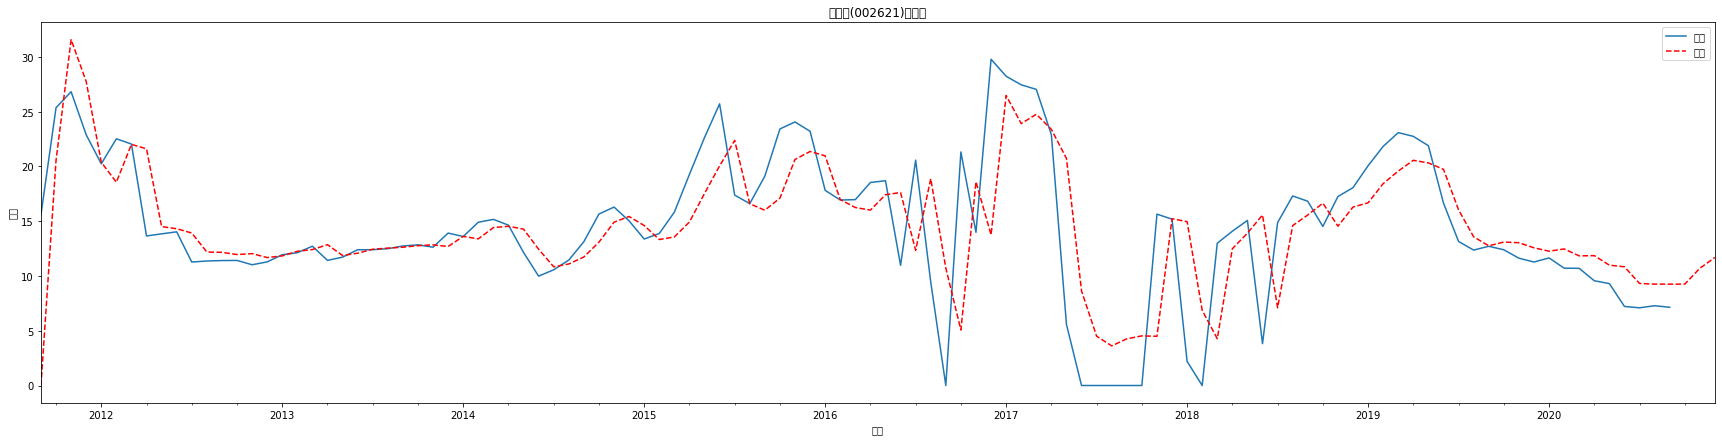

In [5]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

# get_prediction得到的是区间，使用predicted_mean
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean

# 美吉姆预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际')
df_month2.forecast.plot(color='r', ls='--', label='预测')
plt.legend()
plt.title('美吉姆(002621)（月）')
plt.xlabel('时间')
plt.ylabel('价格')
plt.show()